In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

**Import and Read Files**

In [116]:
customer = pd.read_csv("Customer.csv", delimiter=';')
product = pd.read_csv('Product.csv', delimiter = ';')
store = pd.read_csv('Store.csv', delimiter = ';')
transaction = pd.read_csv('Transaction.csv', delimiter = ';')

In [117]:
customer.shape, product.shape, store.shape, transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [118]:
customer.info(), product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


(None, None)

In [119]:
store.info(), transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-n

(None, None)

In [120]:
customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

Drop column who has empty value

In [121]:
customer = customer.dropna()

Replace ',' with '.' to be able to be read as float

In [122]:
customer.loc[:,'Income'] = customer['Income'].replace(',','.', regex = True).astype('float')
customer

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57
...,...,...,...,...,...
441,442,42,1,Married,14.88
443,444,53,0,Married,15.31
444,445,51,0,Married,14.48
445,446,57,0,Married,7.81


In [123]:
product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [124]:
product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [125]:
store.sample()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
13,14,Priangan,Priangan,Modern Trade,"-5,45","105,26667"


In [126]:
store['Latitude'] = store['Latitude'].replace(',','.', regex = True).astype('float')
store['Longitude'] = store['Longitude'].replace(',','.', regex = True).astype('float')
store.sample()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
11,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [127]:
transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [128]:
transaction.sample()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
2584,TR66398,390,03/07/2022,P3,7500,1,7500,8


In [129]:
transaction['Date'] = pd.to_datetime(transaction['Date'], format = '%d/%m/%Y')
transaction.sample()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1272,TR92504,146,2022-03-30,P10,15000,2,30000,3


In [130]:
df_merge = pd.merge(customer, transaction, on = ['CustomerID'])
df_merge = pd.merge(df_merge, store, on = ['StoreID'])
df_merge = pd.merge(df_merge, product.drop(columns = ['Price']), on = ['ProductID'])
df_merge = df_merge.sort_values(by='Date').reset_index(drop = True)
df_merge.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,328,36,0,Married,10.53,TR11369,2022-01-01,P3,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
1,386,33,0,Married,6.95,TR41231,2022-01-01,P9,10000,1,10000,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Yoghurt
2,123,34,0,Married,4.36,TR99839,2022-01-01,P2,3200,6,19200,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Ginger Candy
3,283,19,1,Single,0.0,TR51675,2022-01-01,P10,15000,1,15000,5,Bonafid,Gita,General Trade,-7.250445,112.768845,Cheese Stick
4,51,36,0,Married,7.95,TR54287,2022-01-01,P8,16000,2,32000,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238,Oat


**ARIMA**

Merge Quantity and Sum into one table using .agg and reset index by date

In [131]:
df_regression = df_merge.groupby(['Date']).agg({'Qty':'sum'}).reset_index()
df_regression

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


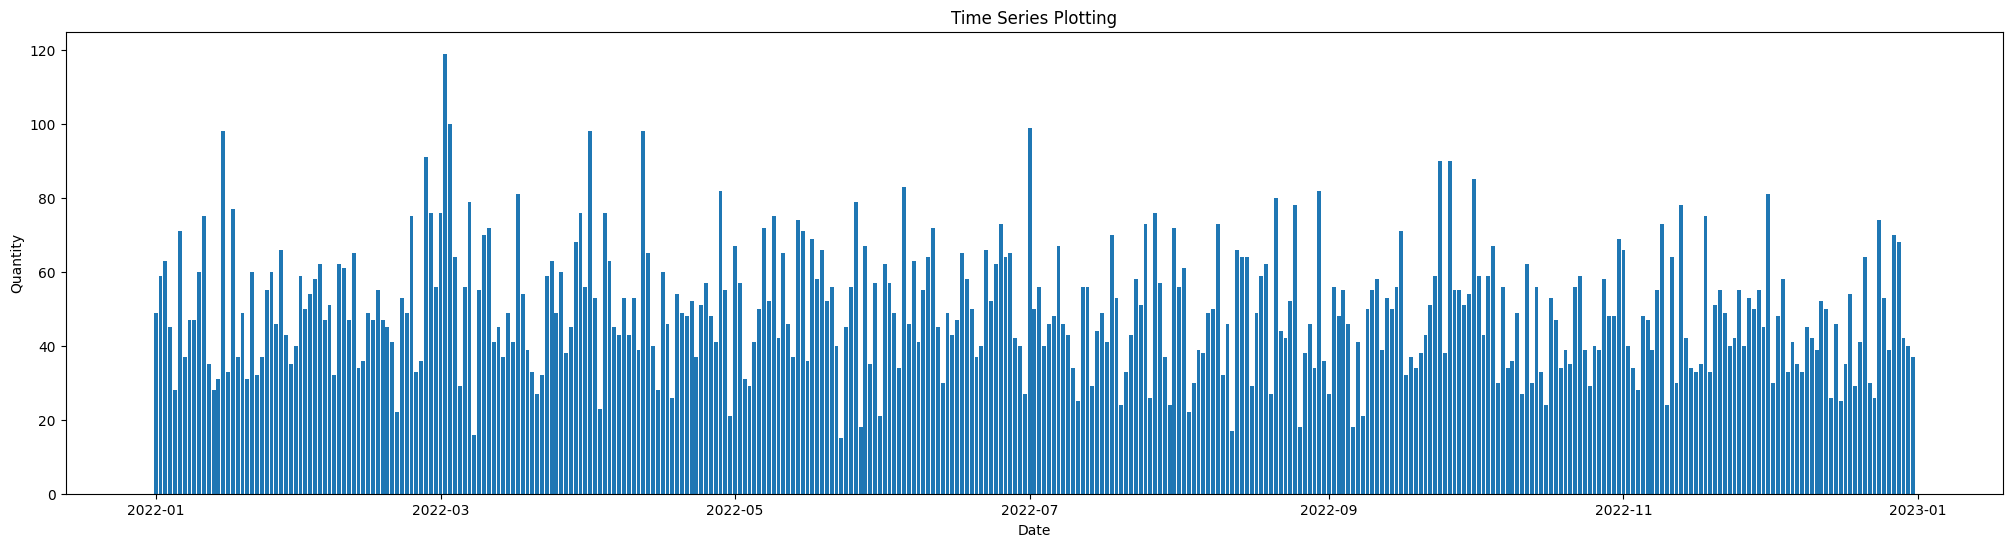

In [132]:
plt.figure(figsize = (25,6))
plt.bar(df_regression['Date'], df_regression['Qty'])


plt.title('Time Series Plotting')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

Data Trend & Seosanality

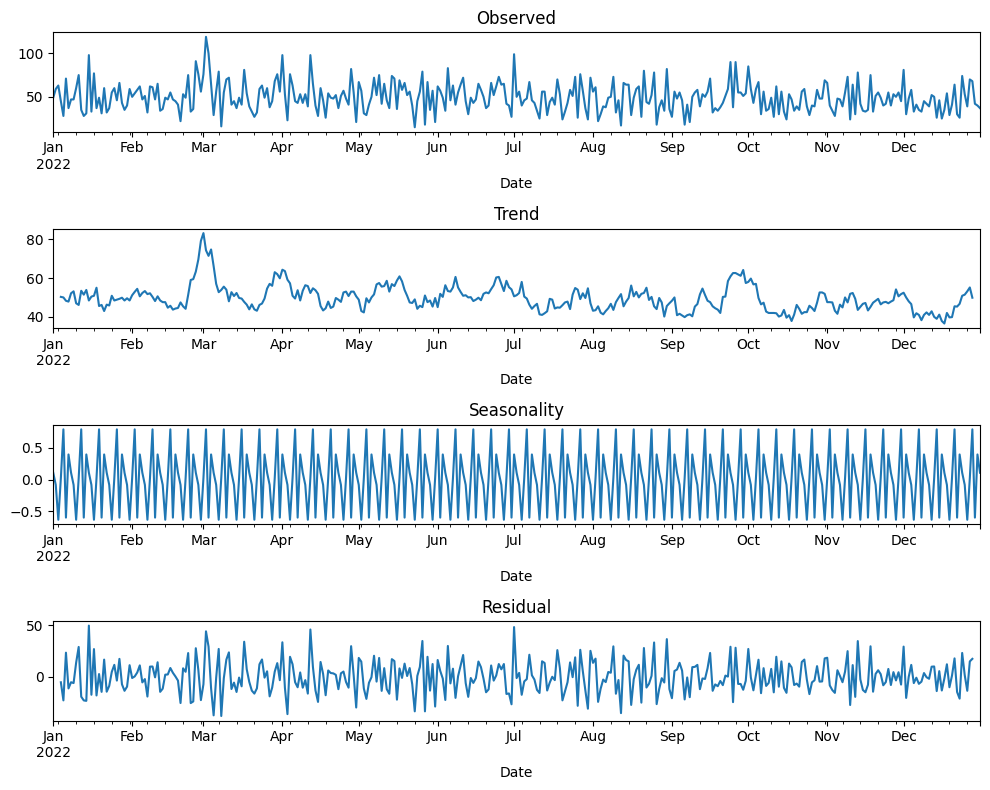

In [133]:
reg_decompose = seasonal_decompose(df_regression.set_index('Date'))

plt.figure(figsize = (10,8))

plt.subplot(411)
reg_decompose.observed.plot(ax = plt.gca())
plt.title('Observed')
plt.subplot(412)
reg_decompose.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(413)
reg_decompose.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(414)
reg_decompose.resid.plot(ax = plt.gca())
plt.title('Residual')
plt.tight_layout()